In [1]:
# Disable GPU
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import os, sys
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import ctypes
import pickle 
import tensorflow as tf
import glob

try:
    import bayesflow as bf
except ModuleNotFoundError: 
    sys.path.extend([
        os.path.abspath(os.path.join("../..")),
        os.path.abspath(os.path.join("../../BayesFlow_dev/BayesFlow/"))
    ])
    import bayesflow as bf
    
import functions_model_comp as prior_simulator_functions

from tensorflow.keras import utils
from joblib import Parallel, delayed
from multiprocessing import Pool
from functools import partial
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import r2_score
from IPython.display import Image, display 

#%load_ext autoreload
#%autoreload 2

2025-05-22 17:46:26.987492: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/administrator/miniconda3/envs/bf/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# Helper function to pass variable N as shared context for model comparison
def variable_n_obs():
    n_obs = prior_simulator_functions.random_num_obs()
    return {'n_obs' : n_obs}

# Custom configurator to handle variable n_obs in model comparison
default_config = bf.configuration.DefaultModelComparisonConfigurator(num_models=4)

def variable_n_obs_configurator(forward_dict):
    config = default_config(forward_dict)
    batch_size = config['model_indices'].shape[0]
    config['direct_conditions'] = np.zeros((batch_size, 1), dtype=np.float32) + np.sqrt(forward_dict['n_obs'])
    return config

# Generative Model

In [4]:
# Generative model
PARAM_NAMES = ['t0', 'st0', 'zr', 'v0',  'v1', 'a', 'alpha', 'szr', 'sv']
PARAM_LABELS = [r"$t_0$", r"$s_{t_0}$", r"$z_r$", r"$v_{0}$", r"$v_{1}$", r"$a$", r"$\alpha$",
               r"$s_{z_r}$", r"$s_{v}$"]
MODEL_NAMES = ["DM_st0", "LFM_st0", "DM_all", "LFM_all"]
MODEL_LABELS = ["Simple DM", "Simple LFM", "Full DM", "Full LFM"]

# Neural networks
NUM_EPOCHS = 250
NUM_ITERATIONS_PER_EPOCH = 10000
BATCH_SIZE = 32
SUMMARY_NET_SETTINGS = {
    "summary_dim" : 20, 
    "num_dense_s1" : 3,
    "num_dense_s2" : 3,
    "num_dense_s3" : 3,
    "num_dense_equivariant" : 3
}
NUM_VAL_SAMPLES = 2000
NUM_ENSEMBLE_MEMBERS = 2

# Global
s = "deadline"
MY_NAME = "ttj_mod_comp_" + str(NUM_EPOCHS) + "ep_" + str(NUM_ITERATIONS_PER_EPOCH) + 'it_' + s
PRESIM_PATH = "/media/administrator/Expansion/"
NUM_PROCESSES = 25 #os.cpu_count()
MY_DPI = 200 #600

print(MY_NAME)

ttj_mod_comp_250ep_10000it_deadline


In [5]:
prior_simulator_functions.levy_prior(fix_alpha=True,
                                     fix_st0=False,
                                     fix_szr=False, fix_sv=False, batch_size=2)

array([[ 0.24095029,  0.11254893,  0.63367206, -4.1968017 ,  3.6581812 ,
         0.29746214,  2.        ,  0.06637602,  0.86821765],
       [ 0.14642945,  0.0396734 ,  0.543284  , -3.0548134 ,  4.538556  ,
         0.32115883,  2.        ,  0.31387943,  1.9920014 ]],
      dtype=float32)

In [6]:
# Prior functions
levy_prior_st0 = bf.simulation.Prior(batch_prior_fun=
                                 partial(prior_simulator_functions.levy_prior, fix_alpha=False,
                                         fix_st0 = False,
                                         fix_szr = True, fix_sv = True),
                                 param_names=PARAM_NAMES)
ddm_prior_st0 = bf.simulation.Prior(batch_prior_fun=
                                 partial(prior_simulator_functions.levy_prior, fix_alpha=True,
                                         fix_st0 = False, 
                                         fix_szr = True, fix_sv = True),
                                 param_names=PARAM_NAMES)
ddm_prior_all = bf.simulation.Prior(batch_prior_fun=
                                 partial(prior_simulator_functions.levy_prior, fix_alpha=True,
                                         fix_st0 = False,
                                         fix_szr = False, fix_sv = False),
                                 param_names=PARAM_NAMES)
levy_prior_all = bf.simulation.Prior(batch_prior_fun=
                                 partial(prior_simulator_functions.levy_prior, fix_alpha=False,
                                         fix_st0 = False,
                                         fix_szr = False, fix_sv = False),
                                 param_names=PARAM_NAMES)

# Simulator functions
if s == "deadline":
    simulator = bf.simulation.Simulator(batch_simulator_fun=
                                        partial(prior_simulator_functions.batch_simulator, 
                                                deadline=True))
else:
    simulator = bf.simulation.Simulator(batch_simulator_fun=
                                        partial(prior_simulator_functions.batch_simulator, 
                                                deadline=False))

# Generative models
ddm_model_st0 = bf.simulation.GenerativeModel(prior=ddm_prior_st0, 
                                          simulator=simulator, name=MODEL_NAMES[0],
                                          #simulator_is_batched=False
                                         )
levy_model_st0 = bf.simulation.GenerativeModel(prior=levy_prior_st0, 
                                          simulator=simulator, name=MODEL_NAMES[2],
                                          #simulator_is_batched=False
                                         )
ddm_model_all = bf.simulation.GenerativeModel(prior=ddm_prior_all, 
                                          simulator=simulator, name=MODEL_NAMES[1],
                                          #simulator_is_batched=False
                                         )
levy_model_all = bf.simulation.GenerativeModel(prior=levy_prior_all, 
                                          simulator=simulator, name=MODEL_NAMES[3],
                                          #simulator_is_batched=False
                                         )
meta_model = bf.simulation.MultiGenerativeModel([ddm_model_st0, levy_model_st0, 
                                                 ddm_model_all, levy_model_all],
                                               shared_context_gen=variable_n_obs) 

INFO:root:Performing 2 pilot runs with the DM_st0 model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 9)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 420, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Performing 2 pilot runs with the DM_all model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 9)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 398, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Performing 2 pilot runs with the LFM_st0 model..

In [7]:
def setup_network(checkpoint_path, 
                  summary_net_settings=SUMMARY_NET_SETTINGS,
                  generative_model=meta_model, 
                  configurator=variable_n_obs_configurator,
                  learning_rate=0.0001 
                 ):
    
    tf.keras.backend.clear_session()

    summary_net = bf.networks.DeepSet(
        summary_dim = summary_net_settings["summary_dim"],
        num_dense_s1 = summary_net_settings["num_dense_s1"],
        num_dense_s2 = summary_net_settings["num_dense_s2"],
        num_dense_s3 = summary_net_settings["num_dense_s3"],
        num_equiv = summary_net_settings["num_dense_equivariant"]
    )

    inference_net = bf.inference_networks.PMPNetwork(num_models=4, num_dense=5, dropout=False)
    amortizer = bf.amortizers.AmortizedModelComparison(inference_net, summary_net)
    
    trainer = bf.trainers.Trainer(amortizer=amortizer, 
                                  generative_model=generative_model,
                                  configurator=configurator, 
                                  checkpoint_path=checkpoint_path, 
                                  default_lr=learning_rate,
                                  memory=True)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=
                                     tf.keras.optimizers.schedules.CosineDecay(
                                         learning_rate, NUM_ITERATIONS_PER_EPOCH*NUM_EPOCHS))
    
    return amortizer, trainer, optimizer

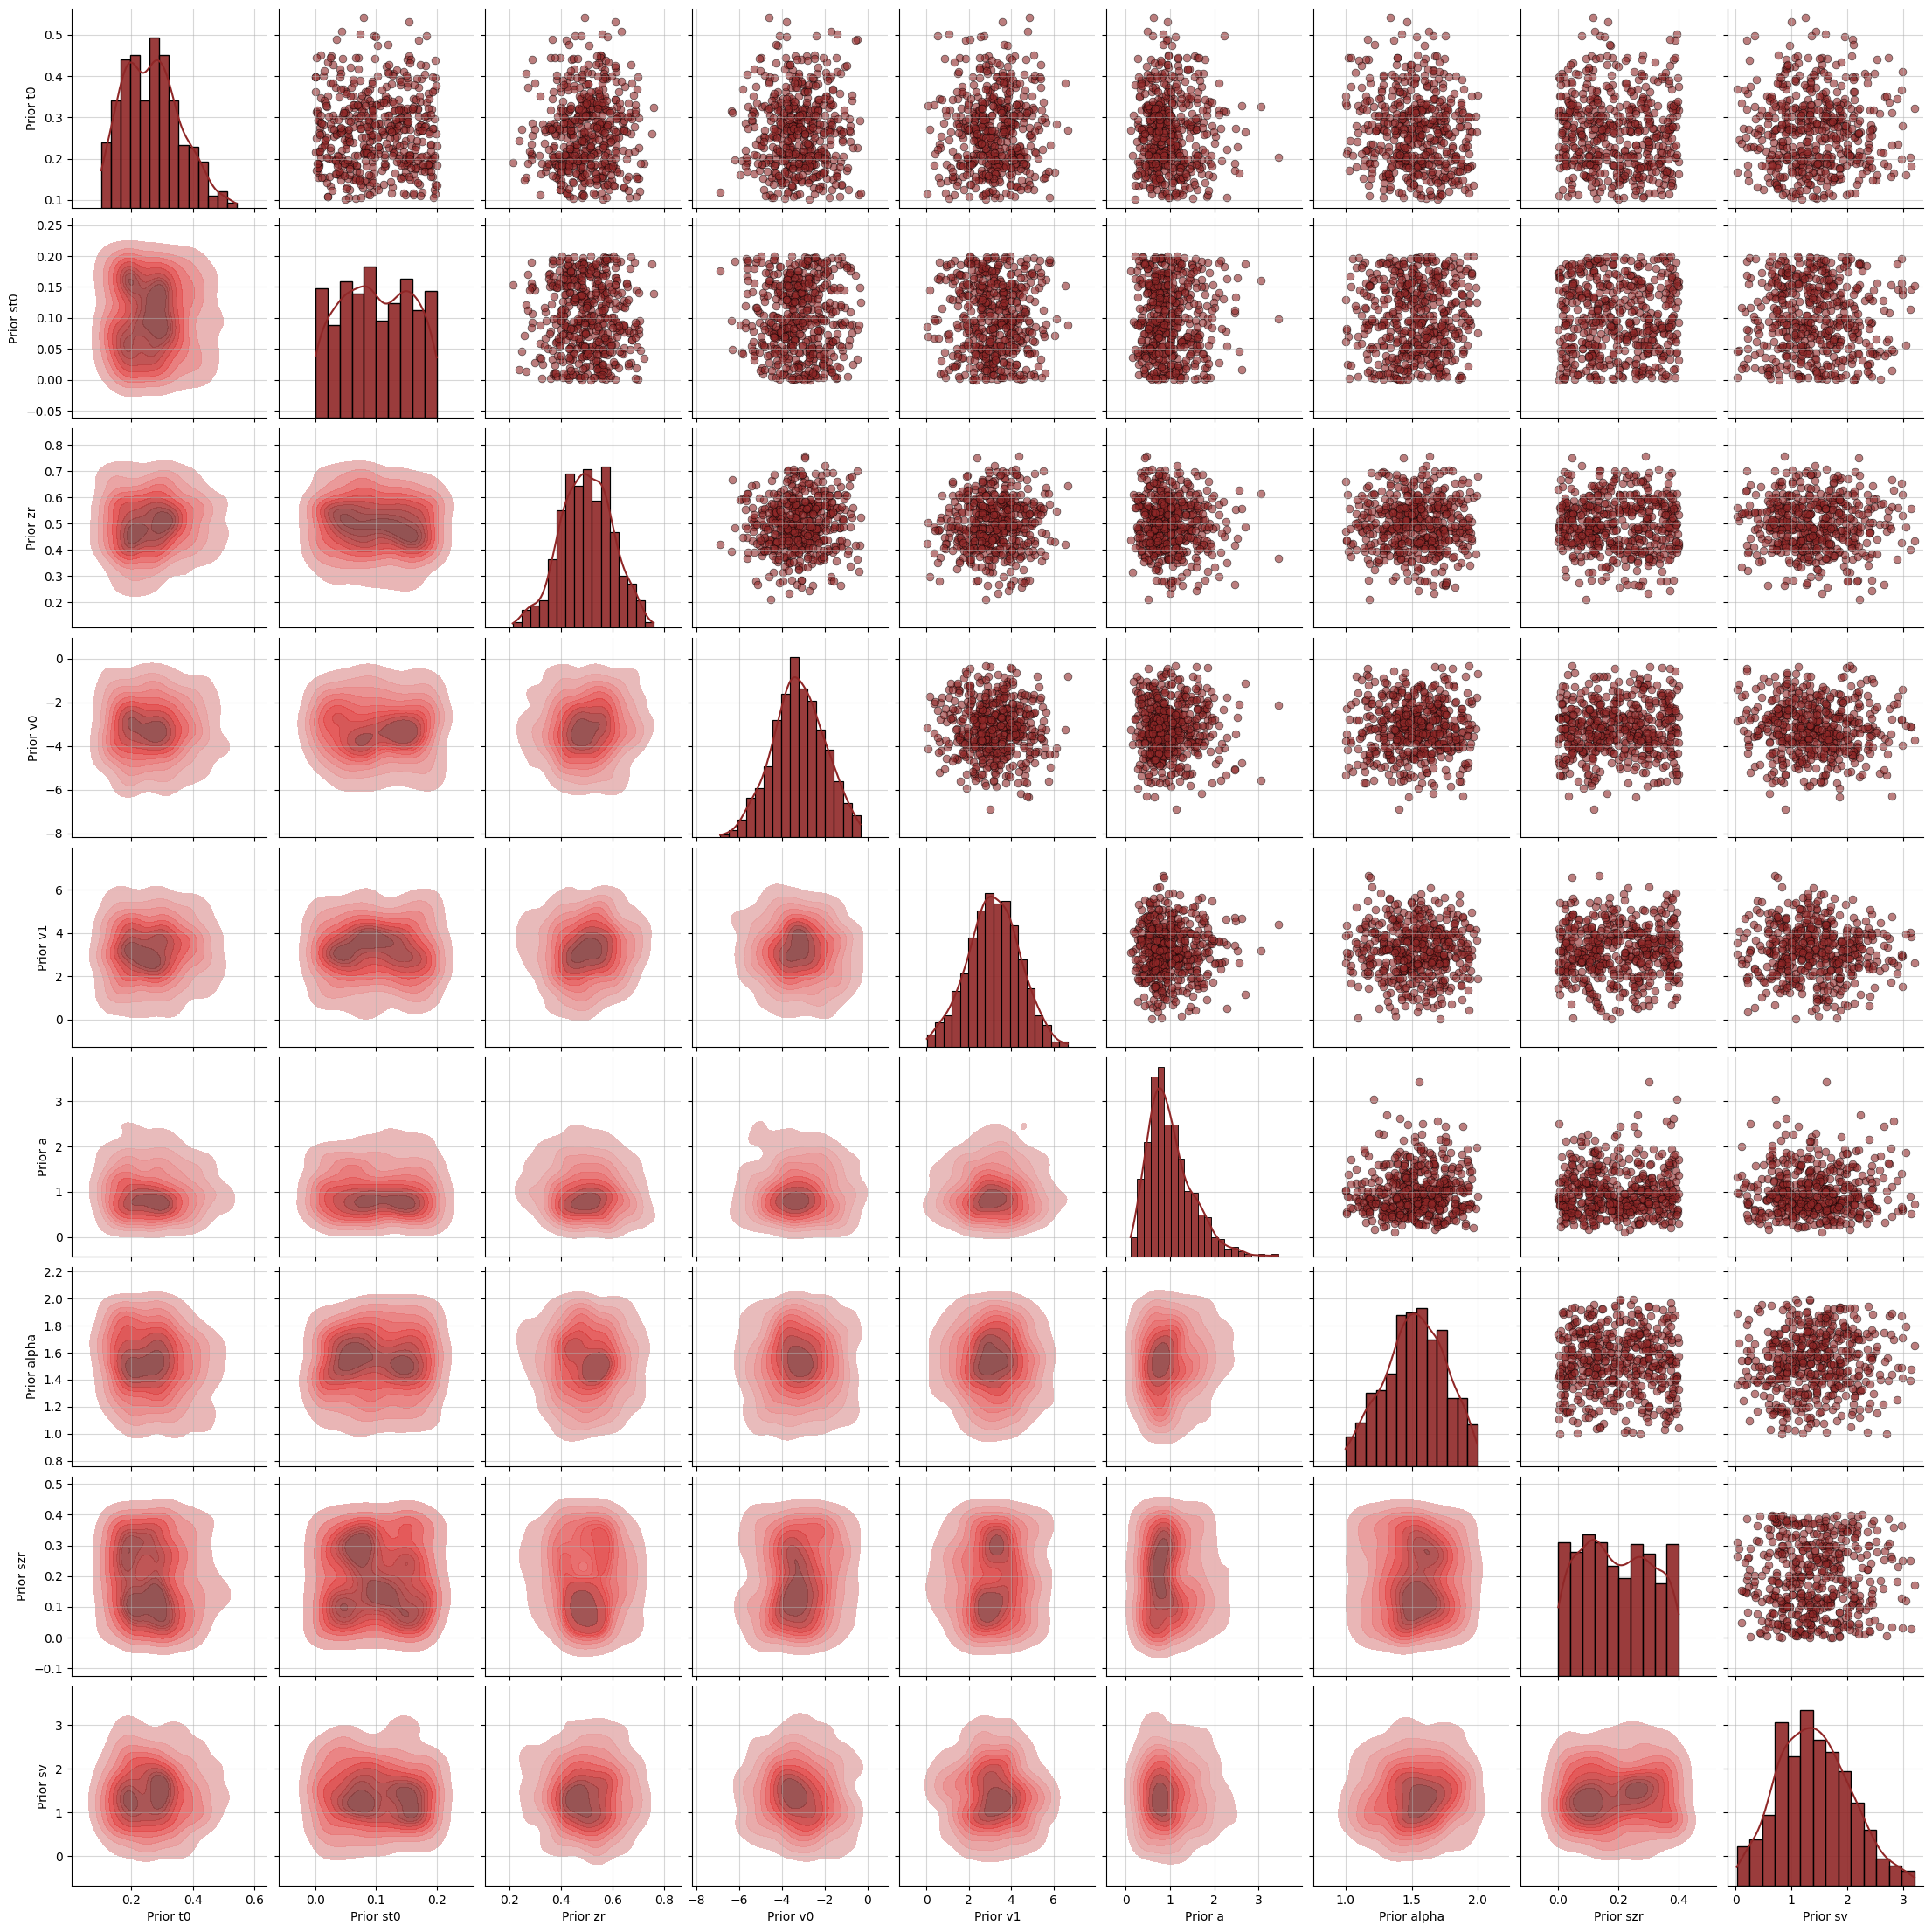

In [8]:
plot = levy_prior_all.plot_prior2d(n_samples=500)

In [9]:
full_levy_prior_samples = prior_simulator_functions.levy_prior(fix_alpha=False,
                                                               fix_st0=False, fix_szr=False, 
                                                               fix_sv=False, 
                                                               batch_size=10000)

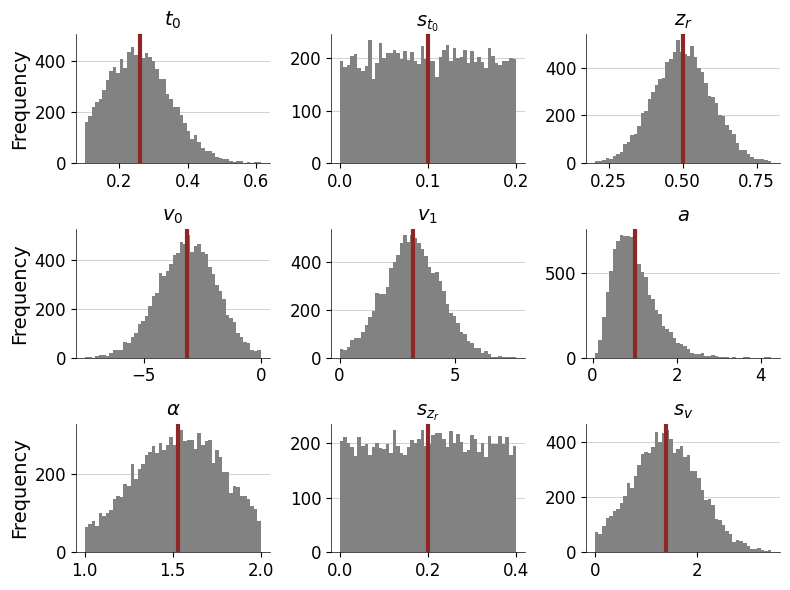

In [10]:
def custom_plot_prior(prior_samples, my_linewidth=1, my_axis_linewidth=0.5, my_fontsize=12):
    
    fig_path = "figures/prior_check.png"
    os.makedirs("figures", exist_ok=True) 

    if not os.path.exists(fig_path):
        n_params = prior_samples.shape[1]
        n_cols = 3 
        n_rows = (n_params + n_cols - 1) // n_cols
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(8, 6))
        axs = axs.flatten()  

        for i in range(n_params):
            ax = axs[i]
            data = prior_samples[:, i]
            mean_value = np.mean(data)

            ax.hist(data, bins=50, color='#828282', zorder=2)
            ax.tick_params(axis='both', labelsize=my_fontsize)
            ax.axvline(mean_value, color="#8f2727", linestyle='-', linewidth=3)
            ax.set_title(PARAM_LABELS[i], fontsize=my_fontsize+2)

            if i % n_cols == 0:  
                ax.set_ylabel('Frequency', fontsize=my_fontsize+2)

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_linewidth(my_axis_linewidth)
            ax.spines['bottom'].set_linewidth(my_axis_linewidth)
            ax.grid(True, which='major', axis='y', color='lightgrey', linestyle='-', linewidth=0.75, zorder=0)

        for i in range(n_params, len(axs)):
            axs[i].axis('off')

        plt.tight_layout()
        plt.savefig(fig_path, dpi=MY_DPI, bbox_inches="tight")
        plt.show()
    else:
        display(Image(filename=fig_path))

custom_plot_prior(full_levy_prior_samples)

# Neural Network Training

## Pre-Simulation

In [11]:
def f(x, presim_path):
    file_path = os.path.join(presim_path, f'presim_file_{x}.pkl')
    with open(file_path, 'wb+') as file:
        for k in range(NUM_ITERATIONS_PER_EPOCH):
            presim_res = meta_model(BATCH_SIZE)
            pickle.dump(presim_res, file)

def multipickle_loader(file_path):
    sim_dicts = []
    with open(file_path, 'rb') as f:
        try:
            while True:
                sim_dicts.append(pickle.load(f))
        except EOFError:
            pass
    return sim_dicts

In [12]:
if __name__ == '__main__':
    FULL_PRESIM_PATH = os.path.join(PRESIM_PATH, MY_NAME)
    if not os.path.exists(FULL_PRESIM_PATH):
        os.makedirs(FULL_PRESIM_PATH)
        with Pool(processes=NUM_PROCESSES) as pool:
            presim_function = partial(f, presim_path=FULL_PRESIM_PATH)
            pool.map(presim_function, range(NUM_EPOCHS))

## Training Phase

INFO:root:Loaded loss history from checkpoint_ttj_mod_comp_250ep_10000it_deadline/net1/history_250.pkl.
INFO:root:Loaded simulation memory from checkpoint_ttj_mod_comp_250ep_10000it_deadline/net1/memory.pkl
INFO:root:Networks loaded from checkpoint_ttj_mod_comp_250ep_10000it_deadline/net1/ckpt-250
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
/home/administrator/miniconda3/envs/bf/lib/python3.10/site-packages/bayesflow/diagnostics.py:899: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  f.tight_layout()
INFO:root:Loaded loss history from checkpoint_ttj_mod_comp_250ep_10000it_deadline/net2/history_250.pkl.
INFO:root:Loaded simulation memory from checkpoint_ttj_mod_comp_250ep_10000it_deadline/net2/memory.pkl
INFO:root:Networks loaded from checkpoint_ttj_mod_comp_250ep_10000it_deadline/net2/ckpt-250
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
/home/administrator/miniconda3

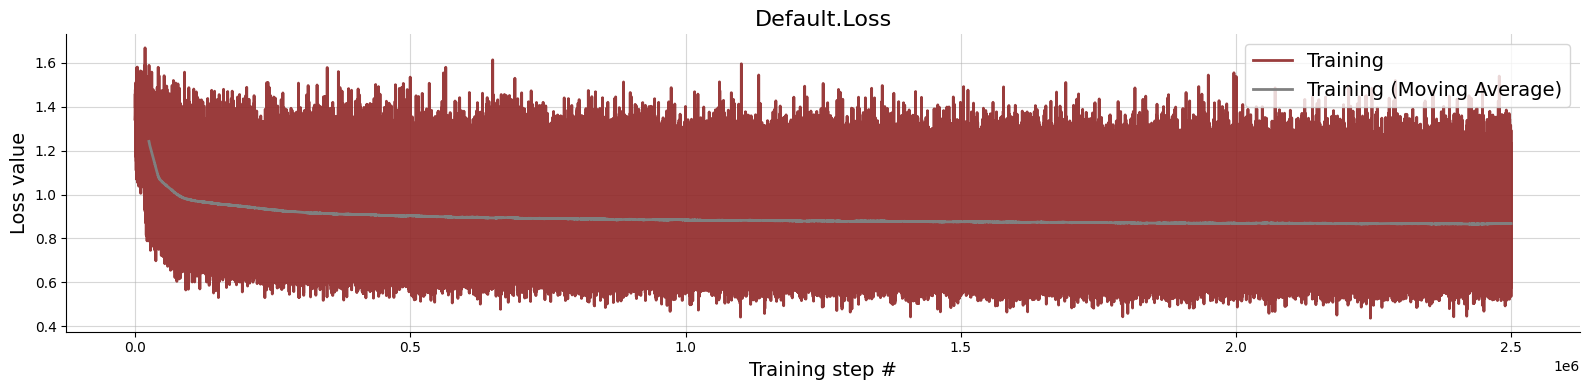

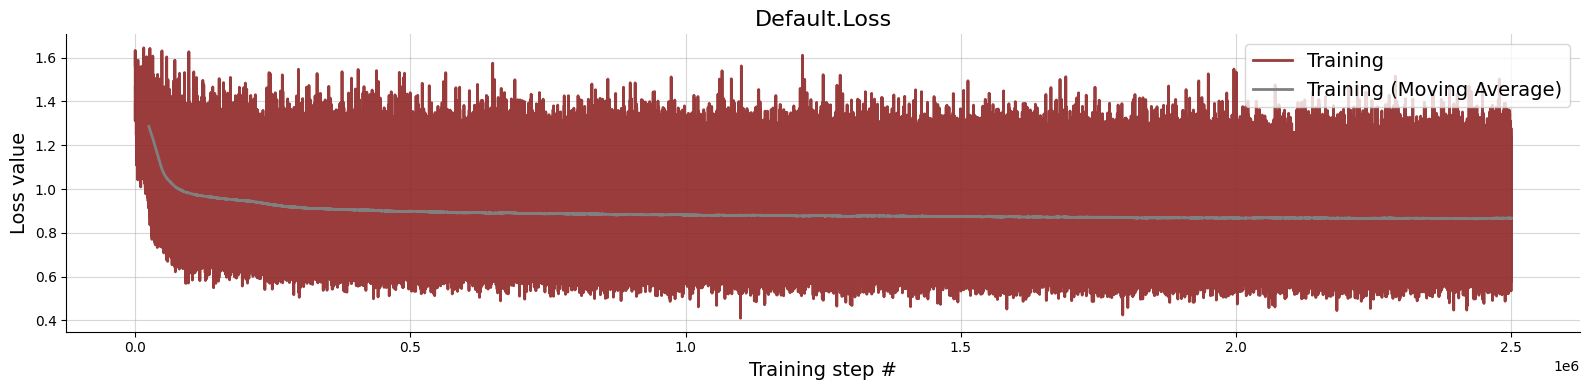

In [13]:
for network in range(NUM_ENSEMBLE_MEMBERS):
    amortizer, trainer, optimizer = setup_network(checkpoint_path=f"checkpoint_{MY_NAME}/net{network+1}")
    if not os.path.exists(f"checkpoint_{MY_NAME}/net{network+1}"):
        losses = trainer.train_from_presimulation(FULL_PRESIM_PATH,
                                                  optimizer=optimizer,
                                                  reuse_optimizer=True,
                                                  custom_loader=multipickle_loader)
    diag_plot = bf.diagnostics.plot_losses(trainer.loss_history.get_plottable(), moving_average=True)

## Network Validation

In [14]:
# File paths
VAL_ROOT_PATH = "validation_files"
os.makedirs(VAL_ROOT_PATH, exist_ok=True)
SIM_INDICES_FILE = VAL_ROOT_PATH + "/sim_indices_" + MY_NAME + ".pkl"
SIM_PRED_FILE = VAL_ROOT_PATH + "/sim_pred_" + MY_NAME + ".pkl"

def save_data(data, file_path):
    with open(file_path, "wb") as f:
        pickle.dump(data, f)

def load_data(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(f)

if all(os.path.exists(file) for file in [SIM_INDICES_FILE, SIM_PRED_FILE]):
    print("Loading previously saved data...")
    sim_indices = load_data(SIM_INDICES_FILE)
    sim_pred = load_data(SIM_PRED_FILE)
    print("Data loaded succesfully.")
else:
    print("Generating new data...")
    
    # Generate some validation data
    amortizer, trainer, optimizer = setup_network(checkpoint_path=f"checkpoint_{MY_NAME}/net1")
    sim_data = meta_model(NUM_VAL_SAMPLES)
    sim_data_transformed = variable_n_obs_configurator(sim_data)
    sim_indices = sim_data_transformed["model_indices"]
    sim_pred = amortizer(sim_data_transformed)
    # Save data to files
    print("Saving data...")
    save_data(sim_indices, SIM_INDICES_FILE)
    save_data(sim_pred, SIM_PRED_FILE)
    print("Data saved successfully.")

Loading previously saved data...
Data loaded succesfully.


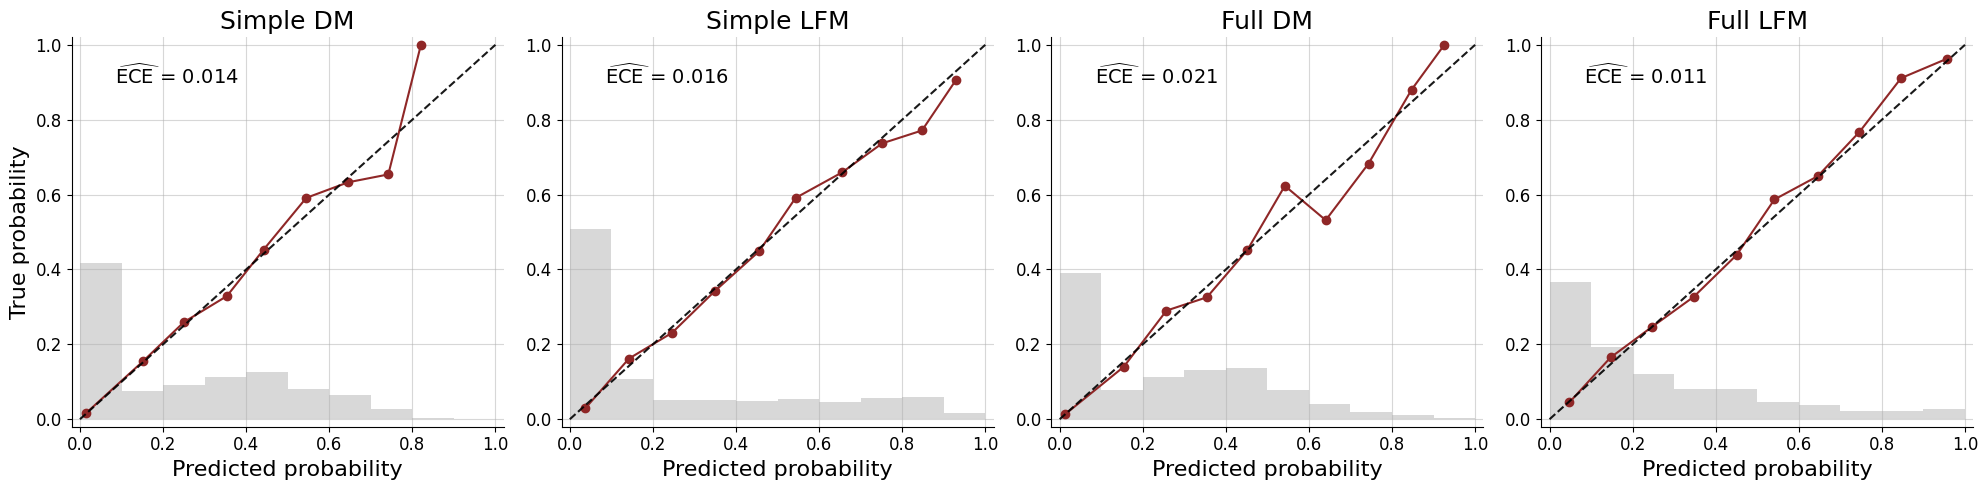

In [15]:
bf.diagnostics.plot_calibration_curves(true_models=sim_indices,
                                       pred_models=sim_pred,
                                       model_names=MODEL_LABELS,
                                      )
plt.savefig(f"figures/comp_calibration_{s}.png", dpi=MY_DPI, bbox_inches="tight")

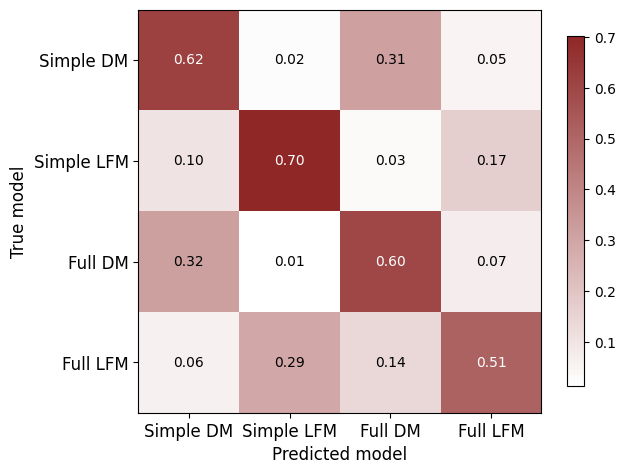

In [16]:
conf_matrix = bf.diagnostics.plot_confusion_matrix(true_models=sim_indices, 
                                                   pred_models=sim_pred,
                                                   model_names=MODEL_LABELS,
                                                   fig_size=(6.5, 6.5),
                                                   title=False
                                                  )
plt.savefig(f"figures/comp_confusion_{s}.png", dpi=MY_DPI, bbox_inches="tight")

## Network Application

In [17]:
# Load empirical data
DATA_PATH = "data/individual_data/"
ESTIM_ROOT_PATH = "estimates_model_comp"

In [18]:
for network in range(NUM_ENSEMBLE_MEMBERS):
    estimates_path = f'{ESTIM_ROOT_PATH}/{MY_NAME}_estimates_net{network + 1}.csv'
    
    if not os.path.exists(estimates_path):  
        amortizer, trainer, optimizer = setup_network(checkpoint_path=f"checkpoint_{MY_NAME}/net{network+1}")

        if s == "no_deadline":
            datafiles = glob.glob(DATA_PATH + '*.csv')
        else:
            datafiles = glob.glob(DATA_PATH+'*explicitDeadline.csv') 
            
        preds = []   
        
        for datafile in datafiles:
            raw_data = pd.read_csv(datafile)
            if ("explicitDeadline" in datafile) & (s == "no_deadline"):
                raw_data = raw_data.loc[raw_data['RT'] != 0] #Delete timeouts
            data = np.expand_dims(raw_data.to_numpy(), 0)
            data = np.delete(data, 1, axis = 2) #Delete letter column
            #Negative rts = letter/0, positive RTs = number/1
            thisdict = {"summary_conditions": data, "direct_conditions": np.zeros((1, 1), dtype=np.float32) + np.sqrt(data.shape[1])}
            samples = amortizer.posterior_probs(thisdict, to_numpy=True)
            preds.append(samples)
            
        preds = np.array(preds)[:, 0, :]
        df = pd.DataFrame(preds, columns=MODEL_NAMES)
        df['file'] = [os.path.basename(filepath) for filepath in datafiles]  
        df[['pp', 'condition']] = df['file'].str.extract(r'file(\d+)_(acc|implicitDeadline|explicitDeadline)\.csv')
        df.to_csv(estimates_path, index=False)

        print(f"Saved estimates to {estimates_path}")
    else:
        print(f"{estimates_path} already exists")

estimates_model_comp/ttj_mod_comp_250ep_10000it_deadline_estimates_net1.csv already exists
estimates_model_comp/ttj_mod_comp_250ep_10000it_deadline_estimates_net2.csv already exists


## Ensemble Agreement

In [19]:
def plot_ensemble_agreement(
    net1_estimates,
    net2_estimates,
    param_names=None,
    fig_size=None,
    label_fontsize=16,
    title_fontsize=18,
    metric_fontsize=16,
    tick_fontsize=12,
    add_corr=True,
    add_r2=True,
    color="#8f2727",
    n_col=None,
    n_row=None,
    xlabel="Network 1",
    ylabel="Network 2",
    **kwargs,
):
    """ Alters bf.diagnostics.plot_recovery to show the degree of agreement between two ensemble members."""

    # Determine n params and param names if None given
    n_params = net1_estimates.shape[-1]
    if param_names is None:
        param_names = [f"$\\theta_{{{i}}}$" for i in range(1, n_params + 1)]

    # Determine number of rows and columns for subplots based on inputs
    if n_row is None and n_col is None:
        n_row = int(np.ceil(n_params / 6))
        n_col = int(np.ceil(n_params / n_row))
    elif n_row is None and n_col is not None:
        n_row = int(np.ceil(n_params / n_col))
    elif n_row is not None and n_col is None:
        n_col = int(np.ceil(n_params / n_row))

    # Initialize figure
    if fig_size is None:
        fig_size = (int(4 * n_col), int(4 * n_row))
    f, axarr = plt.subplots(n_row, n_col, figsize=fig_size)

    if n_col > 1 or n_row > 1:
        axarr_it = axarr.flat
    else:
        axarr_it = [axarr]

    for i, ax in enumerate(axarr_it):
        if i >= n_params:
            break

        # Add scatter and error bars
        _ = ax.scatter(net1_estimates[:, i], net2_estimates[:, i], alpha=0.5, color=color, **kwargs)

        # Make plots quadratic to avoid visual illusions
        lower = min(net1_estimates[:, i].min(), net2_estimates[:, i].min())
        upper = max(net1_estimates[:, i].max(), net2_estimates[:, i].max())
        eps = (upper - lower) * 0.1
        ax.set_xlim([lower - eps, upper + eps])
        ax.set_ylim([lower - eps, upper + eps])
        ax.plot(
            [ax.get_xlim()[0], ax.get_xlim()[1]],
            [ax.get_ylim()[0], ax.get_ylim()[1]],
            color="black",
            alpha=0.9,
            linestyle="dashed",
        )

        # Add optional metrics and title
        if add_r2:
            r2 = r2_score(net1_estimates[:, i], net2_estimates[:, i])
            ax.text(
                0.1,
                0.9,
                "$R^2$ = {:.3f}".format(r2),
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                size=metric_fontsize,
            )
        if add_corr:
            corr = np.corrcoef(net1_estimates[:, i], net2_estimates[:, i])[0, 1]
            ax.text(
                0.1,
                0.8,
                "$r$ = {:.3f}".format(corr),
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                size=metric_fontsize,
            )
        ax.set_title(param_names[i], fontsize=title_fontsize)

        # Prettify
        sns.despine(ax=ax)
        ax.grid(alpha=0.5)
        ax.tick_params(axis="both", which="major", labelsize=tick_fontsize)
        ax.tick_params(axis="both", which="minor", labelsize=tick_fontsize)

    # Only add x-labels to the bottom row
    bottom_row = axarr if n_row == 1 else axarr[0] if n_col == 1 else axarr[n_row - 1, :]
    for _ax in bottom_row:
        _ax.set_xlabel(xlabel, fontsize=label_fontsize)

    # Only add y-labels to right left-most row
    if n_row == 1:
        axarr[0].set_ylabel(ylabel, fontsize=label_fontsize)
    else:
        for _ax in axarr[:, 0]:
            _ax.set_ylabel(ylabel, fontsize=label_fontsize)

    for _ax in axarr_it[n_params:]:
        _ax.remove()

    f.tight_layout()
    return f

In [20]:
net1_pred = pd.read_csv(f"{ESTIM_ROOT_PATH}/{MY_NAME}_estimates_net1.csv", 
                        index_col='pp').drop(columns=['file', 'condition'], axis=1)
net2_pred = pd.read_csv(f"{ESTIM_ROOT_PATH}/{MY_NAME}_estimates_net2.csv", 
                        index_col='pp').drop(columns=['file', 'condition'], axis=1)

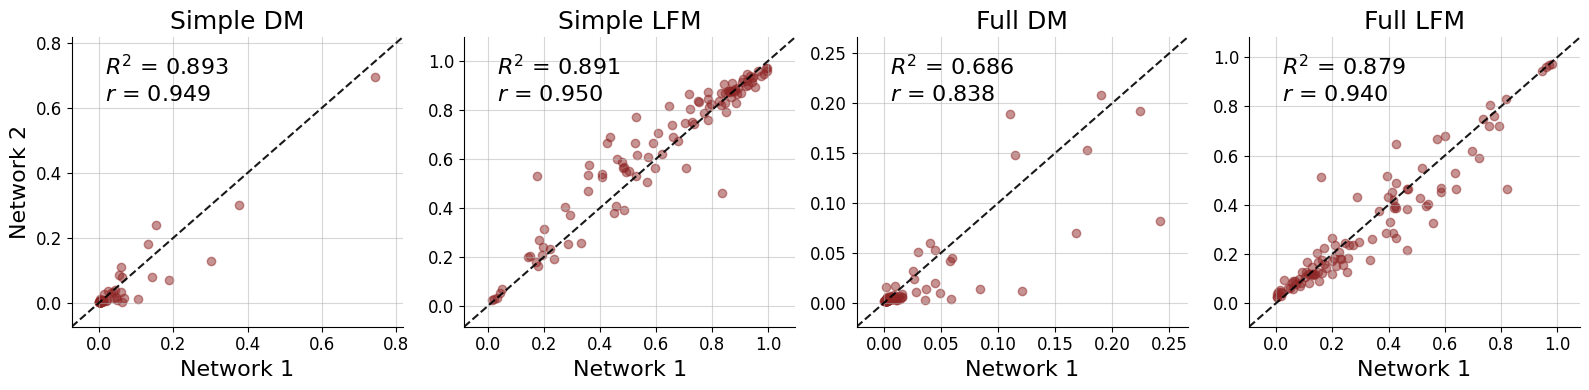

In [21]:
plot_ensemble_agreement(
            net1_estimates=np.array(net1_pred),
            net2_estimates=np.array(net2_pred),
            xlabel="Network 1",
            ylabel="Network 2",
            param_names=MODEL_LABELS,
            add_corr=True,
            add_r2=True,
            color="#8f2727",
        )
plt.savefig(f"figures/comp_agree_{s}.png", dpi=MY_DPI, bbox_inches="tight")